In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
data = ascii.read('../comb05.spec')
lamda_galaxy = data['col1']
spectra_galaxy = data['col2']
variance_spectra_galaxy = data['col3']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
print(lamda_galaxy_range)

[5561.54, 8116.54]


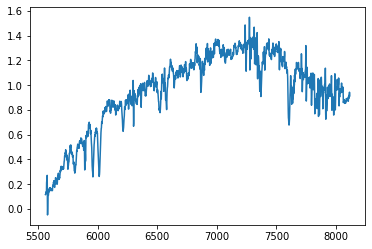

In [3]:
spectra_galaxy = spectra_galaxy / np.median(spectra_galaxy)
plt.plot(lamda_galaxy, spectra_galaxy)

In [4]:
c = 299792.458                                 # speed of light in km/s
frac_lamda = lamda_galaxy[1]/ lamda_galaxy[0]  # Constant lambda fraction per pixel
velocity_scale =  np.log(frac_lamda)*c         # velocity scale in km/s per pixel
print('Velocity_scale=', velocity_scale)

Velocity_scale= 67.373149497962


In [5]:
spectra_galaxy_new, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, spectra_galaxy, 
                                                         velscale=velocity_scale)

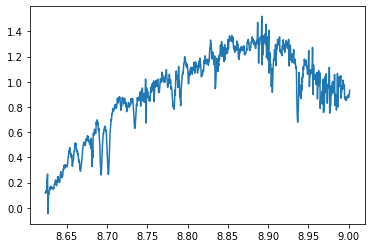

In [6]:
plt.plot(log_lamda_galaxy, spectra_galaxy_new)

In [7]:
template_data = ascii.read('../TEXT/101484.txt')
lamda_template = template_data['col1']                      # wavelength in angstrom
spectra_template = template_data['col2']                     # spectra
lamda_template_range = [np.min(lamda_template), np.max(lamda_template)]
print(lamda_template_range)

[3465.0, 9469.0]


In [8]:
z = 0.516 
lam_range_min = lamda_template_range[0]*(1+z)
lam_range_max = lamda_template_range[1]*(1+z)
print(lam_range_min)
print(lam_range_max)

5252.94
14355.004


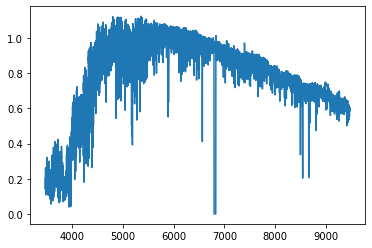

In [9]:
plt.plot(lamda_template, spectra_template)

In [10]:
spectra_template_new, log_lamda_template, vscale = util.log_rebin(lamda_template_range, spectra_template,
                                                                  velscale=velocity_scale)

In [11]:
z = 0.516               # redshift from input spectra
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.]  

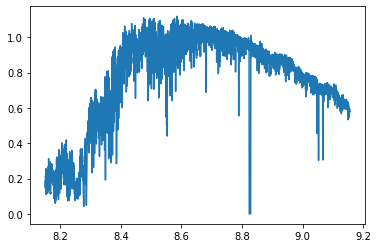

In [12]:
plt.plot(log_lamda_template, spectra_template_new)

In [13]:
noise = np.full_like(spectra_galaxy_new, 0.0166)

In [14]:
sigma_instrument = 1.7                           #sigma of the instrumental LSF
#pixel_size_gal_spec = 1.25  #(frac_lamda - 1.0) * lamda_galaxy   # pixel size in Angstrom
fwhm_galaxy = 2.355 * sigma_instrument           # FWHM of every pixel in Angstrom
#print(pixel_size_gal_spec)
fwhm_galaxy_spectra  = np.full(len(lamda_galaxy), fwhm_galaxy)
#plt.plot(lamda_galaxy[0:2044], frac_lamda, '.')
#fwhm_galaxy_spectra

### This spectral library consists of spectra for 1273 stars obtained with the 0.9m Coudé Feed telescope at Kitt Peak National Observatory. The spectra have been obtained at an original dispersion of 0.44 Angstroms/pixel, at a resolution of ~1 Angstroms FWHM. To cover the entire wavelength range of 3460 Angstroms to 9464 Angstroms requires five separate observations with different grating settings. These observations have been stitched together to form complete spectra for the individual stars. For 885 stars we have complete coverage over the entire wavelength range, and partial coverage for the remaining stars. The 1273 stars have been selected to provide broad coverage of the atmospheric parameters effective temperature, surface gravity, and [Fe/H], as well as spectral type. The goal of the project is to provide a comprehensive library of stellar spectra for use in automated classification of stellar and galaxy spectra and in galaxy population synthesis.

In [15]:
fwhm_template_spectra = 1.0        # in Angstrom
pixel_size_tem_spec = 0.44           # in Angstrom

In [16]:
fwhm_interp_gal_spec = np.interp(lamda_template, lamda_galaxy, fwhm_galaxy_spectra)  #interpolated fwhm
fwhm_diff = np.sqrt(fwhm_interp_gal_spec**2 - fwhm_template_spectra**2)
sigma_diff = fwhm_diff / 2.355

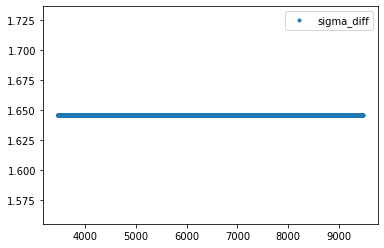

In [17]:
plt.plot(lamda_template, sigma_diff,'.', label='sigma_diff')
plt.legend()

In [18]:
indo_us_library = glob.glob('../TEXT/*')[:850]

In [19]:
templates = np.empty((spectra_template_new.size, len(indo_us_library)))

In [20]:
for j, file_name in enumerate(indo_us_library):
     
    template_data = ascii.read(file_name)
    template_spectra = template_data['col2']

    # perform convolution with variable sigma_diff    
    convolved_temp_spectra= util.gaussian_filter1d(template_spectra, sigma_diff)  

    template_spectra_new = util.log_rebin(lamda_template_range, convolved_temp_spectra, 
                                          velscale=velocity_scale)[0]
    templates[:, j] = template_spectra_new / np.median(template_spectra_new) # Normalizes templates

In [21]:
dv = c*np.log(lamda_template[0]/lamda_galaxy[0]) 

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    124581       260     0.035    -0.032
chi2/DOF: 9.414
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  14 / 850


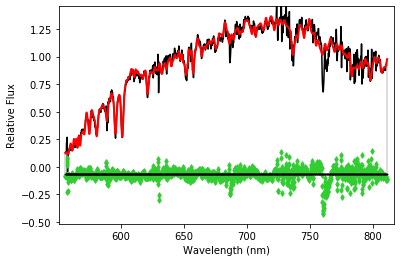

In [22]:
pp = ppxf(templates, spectra_galaxy_new, noise, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, lam=np.exp(log_lamda_galaxy))

In [23]:
def masking(length, pixel_range, log_lamda_gal):
    '''
    This function generate and returns a boolean array with value 'False'
    in the pixel locations which should be excluded from the fit.
    
    Parameters
    ---------------
    length: int
        The length of the logarithmically rebinned galaxy spectra. The 
        boolean array would be of the same size.
        
    pixel_range: list
        A list of tuples where each tuple contains start and end of the
        pixel range needs to be excluded.
        
    log_lamda_gal: array
        This array contains the values of the logarithmically 
        rebinned wavelengths.
    
    Returns
    -------------
    mask : boolean array
        Boolean array with with value 'False' in the pixel locations 
        which should be excluded from the fit.
        
    '''
    
    mask = np.zeros(length, dtype=bool)
    for i,p in enumerate(pixel_range):
        mask |= (log_lamda_gal>=p[0]) & (log_lamda_gal <= p[1])
    return (~mask)

In [24]:
pixel_range = [(8.6263, 8.6274), (8.83376, 8.83622), (8.9349, 8.94475), (8.74788,8.74925), 
               (8.88703, 8.88878), (8.89174, 8.89329), (8.95509, 8.95645)]

In [25]:
mask = masking(spectra_galaxy_new.size, pixel_range, log_lamda_galaxy)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    124568       250     0.002    -0.024
chi2/DOF: 4.58
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  20 / 850


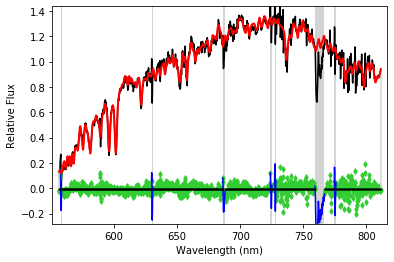

In [26]:
pp = ppxf(templates, spectra_galaxy_new, noise, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, mask=mask, lam=np.exp(log_lamda_galaxy))

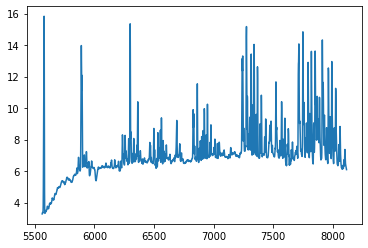

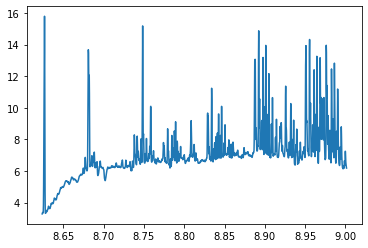

In [28]:
sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy)
noise_new, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range,
                                                             sigma_galaxy_spectra,
                                                           velscale=velocity_scale)
plt.plot(lamda_galaxy, sigma_galaxy_spectra)
plt.figure()
#print(velo_scale)
#print(np.size(noise_new))
plt.plot(log_lamda_noise, noise_new)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    124580       269     0.028     0.000
chi2/DOF: 4.483e-05
method = capfit; Jac calls: 4; Func calls: 22; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  15 / 850


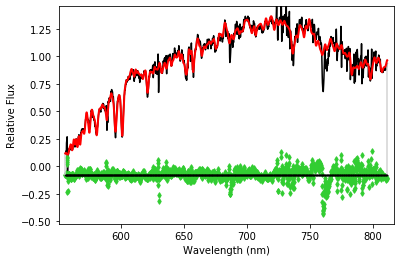

In [31]:
## Fitting with logrithmically rebinned noise and without masking
pp = ppxf(templates, spectra_galaxy_new, noise_new, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, lam=np.exp(log_lamda_galaxy))

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    124565       257     0.001    -0.002
chi2/DOF: 2.058e-05
method = capfit; Jac calls: 4; Func calls: 22; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  18 / 850


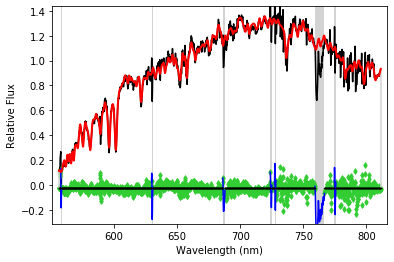

In [32]:
## Fitting with logrithmically rebinned noise and withmasking

pp = ppxf(templates, spectra_galaxy_new, noise_new, velocity_scale, start, moments=4,
         plot=True, vsyst=dv, mask=mask, lam=np.exp(log_lamda_galaxy))